In [2]:
import os
print(os.getcwd())
#os.chdir('/root/Affine/Data')

C:\Users\mrinal


In [3]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2585054154739148355
]


In [5]:
import sys
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
import time
from keras.applications.resnet50 import ResNet50
import h5py
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import seaborn as sns

start = time.time()

In [7]:
# DEV = False
# argvs = sys.argv
# argc = len(argvs)


# if argc > 1 and (argvs[1] == "--development" or argvs[1] == "-d"):
#   DEV = True
# if DEV:
#   epochs = 2
# else:
#   epochs = 100

n_epochs = 100
bs = 8

date = '02012019'
model_name = 'resnet50_softmax_notrain_v1'

train_data_path = './Severe_Accidents/train/'
validation_data_path = './Severe_Accidents/val/'
test_data_path = './Severe_Accidents/test/'
data_annotation_csv_path = './Severe_Accidents/'
model_weights_no_top = '/root/Affine/models/model_weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
save_model_path = '/root/Affine/models/iterations/'
tf_log_path = '/root/Affine/tf-log/new_data/'

In [9]:
from keras import backend as K

tot_num_classes = 38
classes_2 = list(range(1,13))
classes_3 = ['L','R']
classes_4 = ['F','P','B','Y','Z','D']
classes_5 = ['G','M','L','E','H','A']
classes_6 = ['W','N','S']
classes_7 = list(range(1,10))
classes = [classes_2, classes_3, classes_4, classes_5, classes_6, classes_7]

In [10]:
data = pd.read_csv(data_annotation_csv_path + 'Data_Annotation.csv', encoding = 'latin-1')

FileNotFoundError: File b'./Severe_Accidents/Data_Annotation.csv' does not exist

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def one_hot_categorical(x, classes):
    lb_enc = LabelEncoder().fit(np.array(classes).reshape(-1,1))
    label_encoded = lb_enc.transform(x)
    enc = OneHotEncoder(sparse=False).fit(lb_enc.transform(np.array(classes).reshape(-1,1)).reshape(-1,1))
    enc.transform(label_encoded.reshape(-1,1))
    return enc.transform(label_encoded.reshape(-1,1))

y_2 = one_hot_categorical(data['second_code'],classes_2)    
y_3 = one_hot_categorical(data['third_code'],classes_3)
# Including only side crash code 
# Not including R, C, L
y_4 = one_hot_categorical(data['fourth_code'],classes_4)
y_5 = one_hot_categorical(data['fifth_code'],classes_5)
y_6 = one_hot_categorical(data['sixth_code'],classes_6)
y_7 = one_hot_categorical(data['seventh_code'],classes_7)

# Create multi-label targets
targets = np.concatenate((y_2, y_3, y_4, y_5, y_6, y_7), axis = 1)
image_files = pd.DataFrame(targets)
image_files['filename'] = data['file_name'].apply(lambda x: x+'.jpg')
print('Found ' + str(image_files.shape[0]) + ' annotated images')
image_files.shape

Found 211 annotated images


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

(211, 39)

In [8]:
train_ids = [i.split('/')[-1].strip() for i in glob.glob(train_data_path+'*.jpg')]
train_df = image_files.loc[image_files['filename'].isin(train_ids),:].reset_index(drop = True).drop_duplicates()
print(len(train_ids), train_df.shape)

val_ids = [i.split('/')[-1].strip() for i in glob.glob(validation_data_path+'*.jpg')]
val_df = image_files.loc[image_files['filename'].isin(val_ids),:].reset_index(drop = True).drop_duplicates()
print(len(val_ids), val_df.shape)

test_ids = [i.split('/')[-1].strip() for i in glob.glob(test_data_path+'*.jpg')]
test_df = image_files.loc[image_files['filename'].isin(test_ids),:].reset_index(drop = True).drop_duplicates()
print(len(test_ids), test_df.shape)

166 (166, 39)
22 (22, 39)
21 (21, 39)


In [9]:
def split_outputs(generator):
    while True:
        data = next(generator)
        x = data[0]
        y = np.split(data[1], [12,14,20,26, 29], axis=1)
        yield x, y
        
def read_data(img_data_gen, base_dir, in_df, path_col = 'filename',
                        y_col = 'targets', batch_size = 8, n_classes = 38):
    
    print(in_df.shape)
    df_gen = img_data_gen.flow_from_dataframe(in_df, base_dir,
                                              x_col = 'filename', y_col= list(range(n_classes)),
                                              has_ext = True, target_size = (512, 512),
                                              color_mode = 'rgb', class_mode = 'other',
                                              batch_size = batch_size)
    
    return split_outputs(df_gen)

In [10]:
img_train_gen = ImageDataGenerator(rescale=1/255, rotation_range=10,
                                   width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15)
img_val_gen = ImageDataGenerator(rescale=1/255)
img_test_gen = ImageDataGenerator(rescale=1/255)

train_gen = read_data(img_train_gen, train_data_path,train_df,
                                batch_size = bs, n_classes = tot_num_classes)
val_gen = read_data(img_val_gen,validation_data_path, val_df,
                              batch_size = bs,  n_classes = tot_num_classes)
test_gen = read_data(img_test_gen, test_data_path,test_df,
                               batch_size = bs,  n_classes = tot_num_classes)

(166, 39)
Found 166 images.
(22, 39)
Found 22 images.
(21, 39)
Found 21 images.


In [11]:
#from resnet50 import ResNet50
base_model = ResNet50(include_top=False, weights=None)
base_model.load_weights(model_weights_no_top)

/usr/local/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
# Freezing base model
for layer in base_model.layers:
    layer.trainable = False

In [13]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Col 2
x2 = Dense(128, activation='relu')(x)
x2 = BatchNormalization()(x2)
out2 = Dense(len(classes_2), activation='softmax', name = 'col2')(x2)

# Col 3
x3 = Dense(128, activation='relu')(x)
x3 = BatchNormalization()(x3)
out3 = Dense(len(classes_3), activation='softmax', name = 'col3')(x3)

# Col 4
x4 = Dense(128, activation='relu')(x)
x4 = BatchNormalization()(x4)
out4 = Dense(len(classes_4), activation='softmax', name = 'col4')(x4)

# Col 5
x5 = Dense(128, activation='relu')(x)
x5 = BatchNormalization()(x5)
out5 = Dense(len(classes_5), activation='softmax', name = 'col5')(x5)

# Col 6
x6 = Dense(128, activation='relu')(x)
x6 = BatchNormalization()(x6)
out6 = Dense(len(classes_6), activation='softmax', name = 'col6')(x6)

# Col 7
x7 = Dense(128, activation='relu')(x)
x7 = BatchNormalization()(x7)
out7 = Dense(len(classes_7), activation='softmax', name = 'col7')(x7)

In [14]:
from keras.models import Model
model = Model(inputs=base_model.input, outputs=[out2, out3, out4, out5, out6, out7])

In [15]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f384b15fac8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f384b15ff60> False
<keras.layers.convolutional.Conv2D object at 0x7f41f02c9c88> False
<keras.layers.normalization.BatchNormalization object at 0x7f384b13c668> False
<keras.layers.core.Activation object at 0x7f384b13cf60> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f38387cea90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f384b09e940> False
<keras.layers.convolutional.Conv2D object at 0x7f384b0e8c88> False
<keras.layers.normalization.BatchNormalization object at 0x7f3838708da0> False
<keras.layers.core.Activation object at 0x7f3838708f60> False
<keras.layers.convolutional.Conv2D object at 0x7f3838727748> False
<keras.layers.normalization.BatchNormalization object at 0x7f383867c208> False
<keras.layers.core.Activation object at 0x7f383867c630> False
<keras.layers.convolutional.Conv2D object at 0x7f3838617c88> False
<keras.layers.convolution

In [16]:
from keras import backend as K
import tensorflow as tf

def f1(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    TP = tf.count_nonzero(y_pred * y_true, axis=0, dtype = tf.float64)
    FP = tf.count_nonzero(y_pred * (y_true - 1), axis=0, dtype = tf.float64)
    FN = tf.count_nonzero((y_pred - 1) * y_true, axis=0, dtype = tf.float64)

    add_dummy = lambda x: x + K.epsilon()
    precision = TP /  tf.map_fn(add_dummy, (TP + FP))
    recall = TP / tf.map_fn(add_dummy, (TP + FN))
    f1 = 2 * precision * recall / tf.map_fn(add_dummy, (precision + recall))

    weights = tf.reduce_sum(y_true, axis=0)
    weights /= tf.reduce_sum(weights)
    return tf.reduce_sum(f1 * weights)


In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

if not os.path.exists(save_model_path):
  os.mkdir(save_model_path)

model_checkpoint = ModelCheckpoint(save_model_path + date + '_checkpoint_' + model_name +'.model',
                                   monitor='val_loss', 
                                   mode = 'auto', save_best_only=True, verbose=2)

tb_cb = callbacks.TensorBoard(log_dir=tf_log_path, histogram_freq=0)

early_stopping = EarlyStopping(monitor='val_loss', mode = 'auto',patience=30, verbose=2)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode = 'auto',factor=0.8, patience=5, min_lr=1e-4, verbose=2)

cbks = [tb_cb,model_checkpoint,early_stopping,reduce_lr]

In [18]:
from keras.optimizers import Adam

opt = Adam(lr = 1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[f1,"accuracy"])

In [19]:
history = model.fit_generator(train_gen,steps_per_epoch=np.ceil(len(train_ids)/bs),
                    epochs=n_epochs,validation_data=val_gen,
                    validation_steps=1,callbacks=cbks)

Epoch 1/100
21/21 [==============================] - 44s 2s/step - loss: 12.6639 - col2_loss: 3.0608 - col3_loss: 1.0300 - col4_loss: 2.1250 - col5_loss: 2.2745 - col6_loss: 1.4935 - col7_loss: 2.6800 - col2_f1: 0.3467 - col2_acc: 0.0715 - col3_f1: 0.5309 - col3_acc: 0.4404 - col4_f1: 0.4029 - col4_acc: 0.2201 - col5_f1: 0.5362 - col5_acc: 0.1627 - col6_f1: 0.5726 - col6_acc: 0.3194 - col7_f1: 0.4893 - col7_acc: 0.1389 - val_loss: 11.7823 - val_col2_loss: 2.4558 - val_col3_loss: 1.2649 - val_col4_loss: 2.5585 - val_col5_loss: 2.5970 - val_col6_loss: 1.1524 - val_col7_loss: 1.7538 - val_col2_f1: 0.3000 - val_col2_acc: 0.0000e+00 - val_col3_f1: 0.5333 - val_col3_acc: 0.2500 - val_col4_f1: 0.3833 - val_col4_acc: 0.1250 - val_col5_f1: 0.5079 - val_col5_acc: 0.0000e+00 - val_col6_f1: 0.5818 - val_col6_acc: 0.1250 - val_col7_f1: 0.5000 - val_col7_acc: 0.3750

Epoch 00001: val_loss improved from inf to 11.78232, saving model to /root/Affine/models/iterations/02012019_checkpoint_resnet50_softm


Epoch 00017: val_loss did not improve from 6.15777

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 18/100
21/21 [==============================] - 40s 2s/step - loss: 5.8146 - col2_loss: 1.8093 - col3_loss: 0.5728 - col4_loss: 1.3781 - col5_loss: 0.6493 - col6_loss: 0.5793 - col7_loss: 0.8257 - col2_f1: 0.3500 - col2_acc: 0.3276 - col3_f1: 0.5286 - col3_acc: 0.7241 - col4_f1: 0.4037 - col4_acc: 0.4047 - col5_f1: 0.5346 - col5_acc: 0.7103 - col6_f1: 0.5756 - col6_acc: 0.8075 - col7_f1: 0.4889 - col7_acc: 0.6470 - val_loss: 7.6340 - val_col2_loss: 3.0223 - val_col3_loss: 0.5391 - val_col4_loss: 1.2828 - val_col5_loss: 0.7791 - val_col6_loss: 0.8249 - val_col7_loss: 1.1859 - val_col2_f1: 0.3000 - val_col2_acc: 0.0000e+00 - val_col3_f1: 0.5625 - val_col3_acc: 0.8333 - val_col4_f1: 0.4000 - val_col4_acc: 0.3333 - val_col5_f1: 0.5143 - val_col5_acc: 0.6667 - val_col6_f1: 0.5000 - val_col6_acc: 0.5000 - val_col7_f1: 0.5143 - val_col7_acc: 0.3333

Epoch 


Epoch 00026: val_loss did not improve from 6.15777
Epoch 27/100
21/21 [==============================] - 37s 2s/step - loss: 4.6242 - col2_loss: 1.4821 - col3_loss: 0.5126 - col4_loss: 1.1517 - col5_loss: 0.4528 - col6_loss: 0.4483 - col7_loss: 0.5767 - col2_f1: 0.3584 - col2_acc: 0.5038 - col3_f1: 0.5462 - col3_acc: 0.7342 - col4_f1: 0.4030 - col4_acc: 0.5458 - col5_f1: 0.5306 - col5_acc: 0.7680 - col6_f1: 0.5800 - col6_acc: 0.8373 - col7_f1: 0.4943 - col7_acc: 0.7499 - val_loss: 8.3539 - val_col2_loss: 2.9294 - val_col3_loss: 0.8305 - val_col4_loss: 1.5726 - val_col5_loss: 0.7473 - val_col6_loss: 0.7420 - val_col7_loss: 1.5321 - val_col2_f1: 0.3000 - val_col2_acc: 0.0000e+00 - val_col3_f1: 0.5625 - val_col3_acc: 0.8333 - val_col4_f1: 0.3750 - val_col4_acc: 0.5000 - val_col5_f1: 0.5000 - val_col5_acc: 0.5000 - val_col6_f1: 0.5143 - val_col6_acc: 0.6667 - val_col7_f1: 0.5143 - val_col7_acc: 0.3333

Epoch 00027: val_loss did not improve from 6.15777

Epoch 00027: ReduceLROnPlateau redu


Epoch 00035: val_loss did not improve from 6.15777
Epoch 36/100
21/21 [==============================] - 41s 2s/step - loss: 3.5699 - col2_loss: 1.1538 - col3_loss: 0.3134 - col4_loss: 0.9428 - col5_loss: 0.3225 - col6_loss: 0.3937 - col7_loss: 0.4437 - col2_f1: 0.3481 - col2_acc: 0.5972 - col3_f1: 0.5289 - col3_acc: 0.8690 - col4_f1: 0.4221 - col4_acc: 0.6091 - col5_f1: 0.5328 - col5_acc: 0.8592 - col6_f1: 0.5706 - col6_acc: 0.8749 - col7_f1: 0.4832 - col7_acc: 0.8094 - val_loss: 10.2698 - val_col2_loss: 3.3224 - val_col3_loss: 1.6869 - val_col4_loss: 1.5210 - val_col5_loss: 0.6755 - val_col6_loss: 0.5628 - val_col7_loss: 2.5012 - val_col2_f1: 0.3500 - val_col2_acc: 0.1667 - val_col3_f1: 0.5143 - val_col3_acc: 0.6667 - val_col4_f1: 0.4643 - val_col4_acc: 0.6667 - val_col5_f1: 0.5143 - val_col5_acc: 0.6667 - val_col6_f1: 0.5625 - val_col6_acc: 0.8333 - val_col7_f1: 0.5625 - val_col7_acc: 0.1667

Epoch 00036: val_loss did not improve from 6.15777
Epoch 37/100
21/21 [===================

In [20]:
history.history.keys()

dict_keys(['val_loss', 'val_col2_loss', 'val_col3_loss', 'val_col4_loss', 'val_col5_loss', 'val_col6_loss', 'val_col7_loss', 'val_col2_f1', 'val_col2_acc', 'val_col3_f1', 'val_col3_acc', 'val_col4_f1', 'val_col4_acc', 'val_col5_f1', 'val_col5_acc', 'val_col6_f1', 'val_col6_acc', 'val_col7_f1', 'val_col7_acc', 'loss', 'col2_loss', 'col3_loss', 'col4_loss', 'col5_loss', 'col6_loss', 'col7_loss', 'col2_f1', 'col2_acc', 'col3_f1', 'col3_acc', 'col4_f1', 'col4_acc', 'col5_f1', 'col5_acc', 'col6_f1', 'col6_acc', 'col7_f1', 'col7_acc', 'lr'])

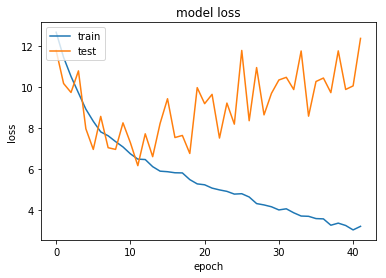

In [21]:
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save(save_model_path + date + '_' + model_name + '_model.h5')
model.save_weights(save_model_path + date + '_' + model_name + '_weights.h5')

#Calculate execution time

end = time.time()
dur = end-start

if dur<60:
    print("Execution Time:",dur,"seconds")
elif dur>60 and dur<3600:
    dur=dur/60
    print("Execution Time:",dur,"minutes")
else:
    dur=dur/(60*60)
    print("Execution Time:",dur,"hours")

Execution Time: 27.401871931552886 minutes


In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [24]:
from keras.models import load_model
model = load_model(save_model_path + date + '_checkpoint_' + model_name +'.model',
                   custom_objects={'f1':f1})

In [25]:
def model_evaluation(model, generator, folder, n_steps):
    eval_metrics = model.evaluate_generator(generator, workers = 1, steps = n_steps)
    print(folder + ' :')
    print('Loss: ' + str(eval_metrics[0]))
    print('Columnwise f1: ',str([eval_metrics[i] for i in range(7, 19, 2)]))
    print()
    
model_evaluation(model, train_gen, 'Train', n_steps = (len(train_ids)// bs + 1))
model_evaluation(model, val_gen, 'Validation', n_steps = (len(val_ids)// bs + 1))
model_evaluation(model, test_gen, 'Test', n_steps = (len(test_ids)// bs + 1))

Train :
Loss: 6.861574293619179
Columnwise f1:  [0.34724129808166865, 0.5406491233605122, 0.4106951099672108, 0.5448911997783134, 0.5743501633853222, 0.49520066332559054]

Validation :
Loss: 7.467403281818736
Columnwise f1:  [0.2826839383064368, 0.5067820507068695, 0.3751081733897706, 0.5096680539072406, 0.5589186808891772, 0.5023809007413462]

Test :
Loss: 7.554320289975121
Columnwise f1:  [0.3588812793872568, 0.51692429006174, 0.417838194181375, 0.5353947096529768, 0.5635401112565228, 0.5134061167603018]



In [26]:
# Need to add rules for predictions

def get_predictions(model, base_dir, generator, in_df, num_classes, n_steps, threshold = 0.5, ):
    
    y_true = np.split(np.array(in_df.loc[:,list(range(num_classes))]), [12,14,20,26, 29], axis=1)
    print(np.array(in_df.loc[:,list(range(num_classes))]).shape)
    true = [np.argmax(x, axis = 1) for x in y_true]
    
    y_pred = model.predict_generator(generator, workers = 1, steps = n_steps)
    pred = [np.argmax(x, axis = 1) for x in y_pred]
    
    return (true, pred)

train_true, train_pred = get_predictions(model, train_data_path, train_gen, train_df,
                                         num_classes = tot_num_classes, n_steps = (len(train_ids)// bs + 1))
val_true, val_pred = get_predictions(model, validation_data_path, val_gen, val_df,
                                     num_classes = tot_num_classes, n_steps = (len(val_ids)// bs + 1))
test_true, test_pred = get_predictions(model, test_data_path, test_gen, test_df,
                                       num_classes = tot_num_classes, n_steps = (len(test_ids)// bs + 1))

(166, 38)
(22, 38)
(21, 38)


In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [28]:
import sklearn.metrics as metrics

def plot_cm(true, pred, classes, i):
    
    le = LabelEncoder().fit(classes)
    report = metrics.confusion_matrix(le.inverse_transform(true), le.inverse_transform(pred),labels = classes)
    plot_confusion_matrix(report,classes, title = 'col_' + str(i))
    
def plot_cm_all_codes(true, pred, list_classes):
    
    for i in range(len(classes)):
        plot_cm(true[i], pred[i], list_classes[i], i+2)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


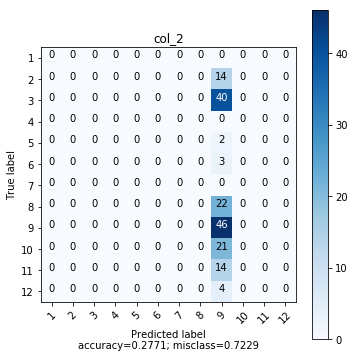

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


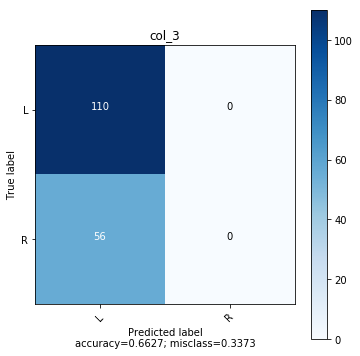

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


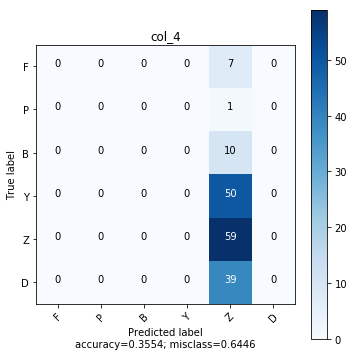

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


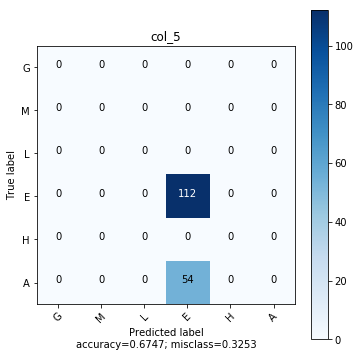

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


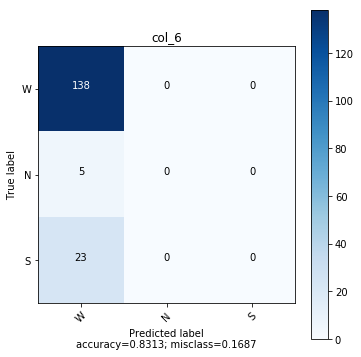

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


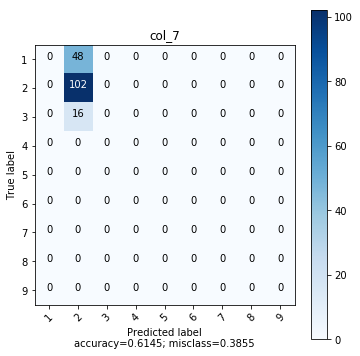

In [29]:
plot_cm_all_codes(train_true, train_pred, classes)

In [30]:
def cm_model_report(writer, folder, true, pred, classes):
    
    print('************' + folder + '*************')
    total_samples = len(true[0])
    start = 0
    m = []
    for i in range(len(classes)):
        
        # Accuracy Metrics
        prf = np.round(metrics.precision_recall_fscore_support(true[i], pred[i], average='weighted')[:-1],4)
        acc = np.round(metrics.accuracy_score(true[i], pred[i]),4)
        metric_list = ['Col'+str(i+2)]
        metric_list.extend(prf)
        metric_list.extend([acc])
        m.append(metric_list)
        print('col_' + str(i+2) + ': ' + str(metric_list))
        
        #Confusion Matrix
        le = LabelEncoder().fit(classes[i])
        report = metrics.confusion_matrix(le.inverse_transform(true[i]), le.inverse_transform(pred[i]),labels = classes[i])
        df = pd.DataFrame(report, columns = classes[i], index = classes[i])
        df.to_excel(writer,sheet_name='CM_' + folder ,startrow=start , startcol=0)   
        start = start + len(classes[i]) + 2
    
    overall_acc = (pd.DataFrame(true) == pd.DataFrame(pred)).all().sum() / total_samples
    print(folder + ' overall accuracy: ', str(np.round(overall_acc *100, 2)))
    metrics_df = pd.DataFrame(m, columns = ['Col','Precision','Recall','F1','Accuracy'])
    metrics_df.to_excel(writer, sheet_name=folder, index = False)
    pd.DataFrame({'Accuracy' : [overall_acc],'Samples':[total_samples]}).to_excel(writer, sheet_name=folder, startrow = 8, index = False)
    print()
    
    return writer


In [31]:
writer = pd.ExcelWriter(save_model_path + date + '_' + model_name + '_report.xlsx', engine='xlsxwriter')
writer = cm_model_report(writer, 'train', train_true, train_pred, classes)    
writer = cm_model_report(writer, 'val', val_true, val_pred, classes) 
writer = cm_model_report(writer, 'test', test_true, test_pred, classes) 
writer.save()

************train*************
col_2: ['Col2', 0.0768, 0.2771, 0.1203, 0.2771]
col_3: ['Col3', 0.4391, 0.6627, 0.5282, 0.6627]
col_4: ['Col4', 0.1263, 0.3554, 0.1864, 0.3554]
col_5: ['Col5', 0.4552, 0.6747, 0.5436, 0.6747]
col_6: ['Col6', 0.6911, 0.8313, 0.7548, 0.8313]
col_7: ['Col7', 0.3776, 0.6145, 0.4677, 0.6145]
train overall accuracy:  5.42

************val*************
col_2: ['Col2', 0.0331, 0.1818, 0.0559, 0.1818]
col_3: ['Col3', 0.4649, 0.6818, 0.5528, 0.6818]
col_4: ['Col4', 0.2066, 0.4545, 0.2841, 0.4545]
col_5: ['Col5', 0.405, 0.6364, 0.4949, 0.6364]
col_6: ['Col6', 0.6694, 0.8182, 0.7364, 0.8182]
col_7: ['Col7', 0.3939, 0.5909, 0.4727, 0.5909]
val overall accuracy:  4.55

************test*************
col_2: ['Col2', 0.0023, 0.0476, 0.0043, 0.0476]
col_3: ['Col3', 0.4444, 0.6667, 0.5333, 0.6667]
col_4: ['Col4', 0.1111, 0.3333, 0.1667, 0.3333]
col_5: ['Col5', 0.3832, 0.619, 0.4734, 0.619]
col_6: ['Col6', 0.6553, 0.8095, 0.7243, 0.8095]
col_7: ['Col7', 0.3832, 0.619, 0.4734

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in lab